# Jupyter - Microsoft SQL Server

Example Jupyter Notebook for Microsoft SQL Server.

```mermaid
flowchart LR
    Jupyter --> LocalDB
```

Jupyter talks to LocalDB. VSCode renders the Jupyter Notebook.

## Dependencies

- SQL Server Express LocalDB, a low resource SQL Server instance ([docs](https://docs.microsoft.com/en-us/sql/database-engine/configure-windows/sql-server-express-localdb))
- [ODBC Driver for SQL Server](https://docs.microsoft.com/en-us/sql/connect/odbc/download-odbc-driver-for-sql-server)

### Install

Install additional dependencies using [Chocolatey](https://chocolatey.org/why-chocolatey).

```powershell
choco install sqllocaldb
choco install sqlserver-odbcdriver
```

[Install Chocolatey](https://chocolatey.org/install)

## Setup

Manage external dependencies.

### LocalDB Instance - MSSQLLocalDB

LocalDB is managed with a tool called [SqlLocalDB](https://docs.microsoft.com/en-us/sql/tools/sqllocaldb-utility).

In [23]:
# List instances
%system SqlLocalDB.exe info

['MSSQLLocalDB']

### ODBC DSNs

ODBC DSNs can be used in lieu of directly managing a connection string. Create a DSN automatically with the helper script:

```powershell
.\scripts\mssql.ps1 | Format-Table -AutoSize -Wrap 	# Run Script
```

`.\scripts\mssql.ps1` is a PowerShell script to help manage MSSQL LocalDB instances. Try `Get-Help .\scripts\mssql.ps1` for additional information.

## Kernel Setup

Configure the Jupyter Kernel.

In [24]:
# ipython-sql enables the %sql and %%sql magic statements
%load_ext sql 

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Connections

Manage DBMS connections.

### List Connections

In [25]:
# List connections
%sql --connections

{'mssql+pyodbc://@(localdb)\\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes': <sql.connection.Connection at 0x2adf519de50>}

### List Drivers

List the drivers available to **pyodbc**.

In [26]:
import pyodbc
pyodbc.drivers()

['SQL Server',
 'ODBC Driver 17 for SQL Server',
 'ODBC Driver 18 for SQL Server']

In [27]:
# Latest driver version
latestDriver = pyodbc.drivers()
latestDriver.sort(reverse=True)
latestDriver.remove('SQL Server')
latestDriver = latestDriver[0]
print('Latest driver: ' + latestDriver)

Latest driver: ODBC Driver 18 for SQL Server


### Open a Connection

In [28]:
import urllib.parse

# Connection with a connection string to (localdb)\MSSQLLocalDB
connection_string = "mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver={d}&trusted_connection=yes".format(d=urllib.parse.quote(latestDriver))
%sql $connection_string

# Connection with ODBC DSN named 'MSSQLLocalDBODBC'
#%sql mssql+pyodbc://@MSSQLLocalDBODBC

### Connection String Format

Connection strings are [SqlAlchemy database URLs](https://docs.sqlalchemy.org/en/14/core/engines.html#database-urls).

Example URL: `mssql+pyodbc://user:pass@(localdb)\LocalDBInstanceName/database?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes`

Deconstructed URL:
- `mssql+pyodbc://`, a URI schema for SqlAlchemy connecting to MSSQL with the pyodbc driver.
- `user:pass` optional credentials that may appear before the `@`.
- `@(localdb)` LocalDB server name **OR** ODBC DSN name. - _note_ `(localdb)` and `(local)` are both localhost MSSQL instances and are different.
	- Use `(local)` for "full" MSSQL Server installations running a local database instance.
	- Use `(localdb)` for "thin" servers running only localDB.
- `\MSSQLLocalDB` LocalDB instance name.
- `/database` database name to connect to
- `?driver=ODBC+Driver+...` pyodbc driver name to use. See **List Drivers** to get a list of available drivers.
- `&trusted_connection=yes` uses Integrated Security for connection credentials.

## Magic Queries

Invoke queries with the `%sql` and `%%sql` magics for single and multi-line queries.

### Single-Line Query

Execute single-line SQL queries with the `%sql` magic statement.

In [29]:
%sql SELECT TOP 10 * FROM INFORMATION_SCHEMA.TABLES;

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
master,dbo,spt_fallback_db,BASE TABLE
master,dbo,spt_fallback_dev,BASE TABLE
master,dbo,spt_fallback_usg,BASE TABLE
master,dbo,spt_values,VIEW
master,dbo,spt_monitor,BASE TABLE
master,dbo,MSreplication_options,BASE TABLE


### Multi-Line Query

Execute multi-line SQL queries with the `%%sql`` magic statement.

**NOTE:** Multiple result in one cell execution raises an error as of 2022/07 with the message:

> Connection is busy with results for another command

In [30]:
%%sql
SELECT
	TOP 10
	*
FROM
	INFORMATION_SCHEMA.TABLES;

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
master,dbo,spt_fallback_db,BASE TABLE
master,dbo,spt_fallback_dev,BASE TABLE
master,dbo,spt_fallback_usg,BASE TABLE
master,dbo,spt_values,VIEW
master,dbo,spt_monitor,BASE TABLE
master,dbo,MSreplication_options,BASE TABLE


### Parameterized SQL Queries

Safely use variables in a SQL query by binding values to a parameterized SQL query. Jupyter Notebooks makes it easy, so there's still no excuse for SQL injection attacks in 2022.

- Define variables in Python: `varname = 'Value'`
- Reference variables in queries: `:varname`

In [31]:
table_types = 'BASE TABLE'
%sql SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE=:table_types;

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
master,dbo,spt_fallback_db,BASE TABLE
master,dbo,spt_fallback_dev,BASE TABLE
master,dbo,spt_fallback_usg,BASE TABLE
master,dbo,spt_monitor,BASE TABLE
master,dbo,MSreplication_options,BASE TABLE


### Bind Query Results to a Variable

Bind query results to a Python variable.

- Single-line assignment syntax: `varname = %sql ...`
- Multi-line assignment syntax: `%%sql varname = << ...`

In [32]:
#-- single-line assignment
result = %sql SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE='BASE TABLE';

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


In [33]:
%%sql result2 <<
-- multi-line assignment
SELECT TOP 5 *
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE='BASE TABLE';

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.
Returning data to local variable result2


### Pass Results in a Variable

Output query data passed between cells. Output from the last cell executed is stored in an automatic variable named `_`.

In [34]:
#-- First cell
#----------------
#-- Save results to a variable.
result = %sql SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE='BASE TABLE';

#-- No cell output

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


In [35]:
#-- SECOND CELL
#----------------
#-- Output results saved from the first cell.
result

TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
master,dbo,spt_fallback_db,BASE TABLE
master,dbo,spt_fallback_dev,BASE TABLE
master,dbo,spt_fallback_usg,BASE TABLE
master,dbo,spt_monitor,BASE TABLE
master,dbo,MSreplication_options,BASE TABLE


### Pass Results in the Automatic Variable: `_`

`_` is an variable containing output from a previously executed cell.

In [36]:
#-- First cell
#----------------
#-- Save results to a variable.
%sql SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE='BASE TABLE';

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
master,dbo,spt_fallback_db,BASE TABLE
master,dbo,spt_fallback_dev,BASE TABLE
master,dbo,spt_fallback_usg,BASE TABLE
master,dbo,spt_monitor,BASE TABLE
master,dbo,MSreplication_options,BASE TABLE


In [37]:
#-- Second cell
#----------------
#-- Obtain results from a variable.
result = _

print('result in tabular format:')
print(result)

result in tabular format:
+---------------+--------------+-----------------------+------------+
| TABLE_CATALOG | TABLE_SCHEMA |       TABLE_NAME      | TABLE_TYPE |
+---------------+--------------+-----------------------+------------+
|     master    |     dbo      |    spt_fallback_db    | BASE TABLE |
|     master    |     dbo      |    spt_fallback_dev   | BASE TABLE |
|     master    |     dbo      |    spt_fallback_usg   | BASE TABLE |
|     master    |     dbo      |      spt_monitor      | BASE TABLE |
|     master    |     dbo      | MSreplication_options | BASE TABLE |
+---------------+--------------+-----------------------+------------+


### Access Result Values

Various ways to access data from query execution results.

In [38]:
print('table columns:')
print(result.keys)
print('first row value: ')
print(result[0])

print('first row, first column: ' + result[0][0])
print('first row and a named column: ' + result[0]["TABLE_NAME"])
print('first row and an object property column: ' + result[0].TABLE_SCHEMA)

table columns:
RMKeyView(['TABLE_CATALOG', 'TABLE_SCHEMA', 'TABLE_NAME', 'TABLE_TYPE'])
first row value: 
('master', 'dbo', 'spt_fallback_db', 'BASE TABLE')
first row, first column: master
first row and a named column: spt_fallback_db
first row and an object property column: dbo


### Execute a Stored Procedure

Execute a stored procedure. Stored Procedures are specific to Microsoft SQL Server in T-SQL.

In [39]:
%%sql
Declare @Out int
EXEC sp_prepexec @Out output,   
    N'@P1 nvarchar(128), @P2 nvarchar(100)',  
    N'SELECT database_id, name  
      FROM sys.databases  
      WHERE name=@P1 AND state_desc = @P2',   
          @P1 = 'tempdb', @P2 = 'ONLINE';   

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


database_id,name
2,tempdb


## Pandas

Process data directly in Python with Pandas DataFrames and the SQLAlchemy ORM.

### Convert Results to a DataFrame

Execute a SQL query and convert the results into a Pandas DataFrame.

In [40]:
#-- Execute a query and save the result as a Pandas DataFrame.
result = %sql SELECT * FROM INFORMATION_SCHEMA.TABLES;
dataframe = result.DataFrame()

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


### Persist a DataFrame to a New Database Table

Save a DataFrame to a new table with the `--persist <variable>` command. The table is named after the DataFrame variable.

In [41]:
%sql --persist dataframe

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes


'Persisted dataframe'

In [42]:
%%sql
-- access the perisisted data
SELECT TOP 10 *
FROM dataframe;

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


index,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,master,dbo,spt_fallback_db,BASE TABLE
1,master,dbo,spt_fallback_dev,BASE TABLE
2,master,dbo,spt_fallback_usg,BASE TABLE
3,master,dbo,spt_values,VIEW
4,master,dbo,spt_monitor,BASE TABLE
5,master,dbo,MSreplication_options,BASE TABLE


### Append a DataFrame to an existing Database Table

In [43]:
#-- Append data to an existing table.
#-- Run this cell multiple times to see the data duplicated after each run.
%sql --append dataframe

#-- Select the perisisted data.
%sql SELECT COUNT(1) as APPENDED_RECORD_CNT FROM dataframe;

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


APPENDED_RECORD_CNT
12


### Drop the Persisted Database Table

In [44]:
#-- cleanup data from example
%sql DROP TABLE dataframe

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


[]

## Matplotlib

[matplotlib](https://matplotlib.org/) is used to plot graphs.

### Configure

Configure matplotlib.

In [45]:
# Produce an inline PNG image instead of opening a GUI application.
%matplotlib inline

### Pie Chart

 * mssql+pyodbc://@(localdb)\MSSQLLocalDB/master?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes
Done.


([<matplotlib.patches.Wedge at 0x2ad86d41490>,
 [Text(-0.9526279098330698, 0.5500000594609756, 'BASE TABLE'),
  Text(0.9526278840857078, -0.5500001040567061, 'VIEW')])

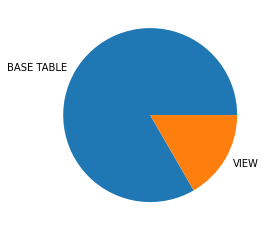

In [46]:
result = %sql SELECT TABLE_TYPE, COUNT(1) FROM INFORMATION_SCHEMA.TABLES GROUP BY TABLE_TYPE;
result.pie()

### Bar Chart

<BarContainer object of 2 artists>

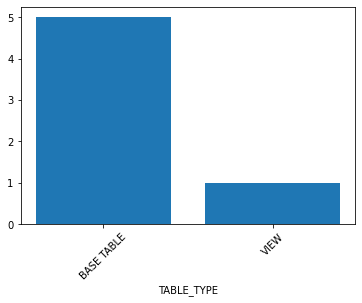

In [47]:
result.bar()